# DoWhy: Interpreters for Causal Estimators

This is a quick introduction to the use of interpreters in the DoWhy causal inference library.
We will load in a sample dataset, use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable and demonstrate how to interpret the obtained results.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

/opt/homebrew/anaconda3/envs/dowhy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(beta=1,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_discrete_common_causes=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
print(df[df.v0==True].shape[0])
df

9585


,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.866517,1.563204,0.326144,1.101909,1.814322,0,True,2.105700
1,1.0,0.129180,0.123532,0.047143,-0.738444,-0.201807,2,True,2.532170
2,1.0,0.608884,1.298506,-0.757838,1.489463,0.498162,2,True,3.415448
3,1.0,0.820697,1.416274,-0.016657,-0.738131,1.252624,2,True,2.923847
4,0.0,0.175293,-0.187661,-0.238175,1.198073,2.697284,1,True,2.496854
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.079275,1.596979,-0.235625,1.620430,2.212075,3,True,4.808887
9996,1.0,0.813991,0.101808,-1.785666,-0.164230,0.602373,2,True,2.073975
9997,1.0,0.011645,0.000355,-1.406359,1.625804,1.711682,3,True,3.928092
9998,1.0,0.716343,-0.917567,-0.248302,-0.623561,1.875534,0,True,0.624727


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the GML graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

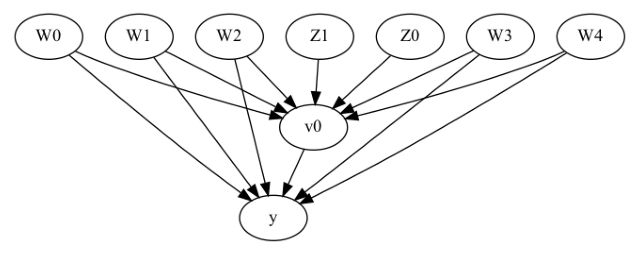

In [5]:
model.view_model()

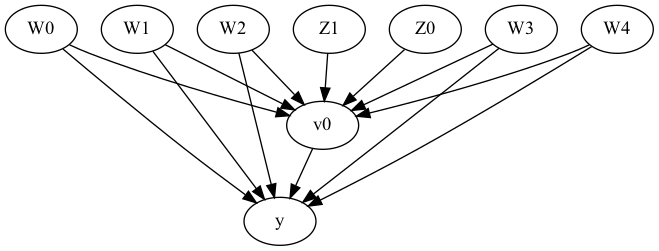

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done.

In [7]:
from dowhy.causal_graph import CausalGraph

graph = data["gml_graph"]
graph

'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

In [8]:
from dowhy.causal_identifier import identify_effect

identified_estimand = identify_effect(model._graph._graph, action_nodes=data["treatment_name"], outcome_nodes=data["outcome_name"], observed_nodes=list(model._graph.get_all_nodes()))
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Method 1: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [10]:
from dowhy.causal_estimator import estimate_effect

estimator_method = "propensity_score_stratification"
causal_estimator_class = dowhy.causal_estimators.get_class_object(estimator_method + "_estimator")
effect_modifiers = model._graph.get_effect_modifiers(data["treatment_name"], data["outcome_name"])
method_params = {}
extra_args = {}

causal_estimator = causal_estimator_class(
                    identified_estimand,
                    **method_params,
                    **extra_args,
                )

causal_estimate_strat  = estimate_effect(df, method_params=method_params, treatment=data["treatment_name"], outcome=data["outcome_name"], estimator=causal_estimator, identifier_name="backdoor", target_units="att", fit_estimator=True, effect_modifiers=effect_modifiers)


print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: att

## Estimate
Mean value: 1.0219082036507277

Causal Estimate is 1.0219082036507277


In [11]:
causal_estimator_class

dowhy.causal_estimators.propensity_score_stratification_estimator.PropensityScoreStratificationEstimator

In [12]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")




print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: att

## Estimate
Mean value: 1.0219082036507277

Causal Estimate is 1.0219082036507277


### Textual Interpreter

The textual Interpreter describes (in words) the effect of unit change in the treatment variable on the outcome variable.

In [13]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.0219082036507277 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


### Visual Interpreter

The visual interpreter plots the change in the standardized mean difference (SMD) before and after Propensity Score based adjustment of the dataset. The formula for SMD is given below.


$SMD = \frac{\bar X_{1} - \bar X_{2}}{\sqrt{(S_{1}^{2} + S_{2}^{2})/2}}$

Here, $\bar X_{1}$ and $\bar X_{2}$ are the sample mean for the treated and control groups.


In [ ]:
# Visual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="propensity_balance_interpreter")

This plot shows how the SMD decreases from the unadjusted to the stratified units. 

## Method 2: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [14]:
from dowhy.causal_estimator import estimate_effect

estimator_method = "propensity_score_matching"
causal_estimator_class = dowhy.causal_estimators.get_class_object(estimator_method + "_estimator")
effect_modifiers = model._graph.get_effect_modifiers(data["treatment_name"], data["outcome_name"])
method_params = {}
extra_args = {}

causal_estimator = causal_estimator_class(
                    identified_estimand,
                    **method_params,
                    **extra_args,
                )

causal_estimate_match  = estimate_effect(df, method_params=method_params, treatment=data["treatment_name"], outcome=data["outcome_name"], estimator=causal_estimator, identifier_name="backdoor", target_units="atc", fit_estimator=True, effect_modifiers=effect_modifiers)


print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: atc

## Estimate
Mean value: 0.9873350447444257

Causal Estimate is 0.9873350447444257


In [15]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: atc

## Estimate
Mean value: 0.9873350447444257

Causal Estimate is 0.9873350447444257


In [16]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 0.9873350447444257 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


Cannot use propensity balance interpretor here since the interpreter method only supports propensity score stratification estimator.

## Method 3: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [17]:
from dowhy.causal_estimator import estimate_effect

estimator_method = "propensity_score_weighting"
causal_estimator_class = dowhy.causal_estimators.get_class_object(estimator_method + "_estimator")
effect_modifiers = model._graph.get_effect_modifiers(data["treatment_name"], data["outcome_name"])
method_params = {"weighting_scheme":"ips_weight"}
extra_args = {}

causal_estimator = causal_estimator_class(
                    identified_estimand,
                    **method_params,
                    **extra_args,
                )

causal_estimate_match  = estimate_effect(df, method_params=method_params, treatment=data["treatment_name"], outcome=data["outcome_name"], estimator=causal_estimator, identifier_name="backdoor", target_units="ate", fit_estimator=True, effect_modifiers=effect_modifiers)

print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 1.6834703508145143

Causal Estimate is 1.6834703508145143


In [18]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W3,W2,W0,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W3,W2,W0,W1,U) = P(y|v0,W4,W3,W2,W0,W1)

## Realized estimand
b: y~v0+W4+W3+W2+W0+W1
Target units: ate

## Estimate
Mean value: 1.6834703508145143

Causal Estimate is 1.6834703508145143


In [19]:
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 1.6834703508145143 in the expected value of the outcome [['y']], over the data distribution/population represented by the dataset.


In [ ]:
interpretation = causal_estimate_ipw.interpret(method_name="confounder_distribution_interpreter", fig_size=(8,8), font_size=12, var_name='W4', var_type='discrete')